# Introduction

Notebook de avaliação de serviço BiopassID ICAO Check em comparação com ground truth FVC-ICAO.

# Import Libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import numpy as np
import pandas as pd

if '../../../../notebooks/' not in sys.path:
    sys.path.insert(0, '../../../../notebooks/')

from net_data_loaders.net_gt_loader import NetGTLoader
from gt_loaders.gt_names import GTName
from utils.constants import ICAO_REQ
from vsoft_evaluator import VsoftEvaluator, DataSource, DataPredSelection

# Load Ground Truth

In [3]:
net_gt_loader = NetGTLoader(aligned=False, gt_names=[GTName.FVC], requisites=list(ICAO_REQ), is_mtl_model=False)
train_data = net_gt_loader.load_gt_data(split='train')
valid_data = net_gt_loader.load_gt_data(split='validation')
test_data = net_gt_loader.load_gt_data(split='test')

Loading GT FVC - TRAIN split...
..Ignoring 0 empty label values
Input data.shape: (4928, 26)
Loading GT FVC - VALIDATION split...
..Ignoring 0 empty label values
Input data.shape: (547, 26)
Loading GT FVC - TEST split...
..Ignoring 0 empty label values
Input data.shape: (288, 26)


# Load Vsoft Data

In [4]:
data_df = pd.read_csv('vsoft_data/compliance_check_vsoft_2.csv')
print('initial data_df.shape: ', data_df.shape)

ignore_imgs = data_df[data_df.mouth == -99].img_name
print('n_imgs to ignore: ', len(ignore_imgs))

data_df = data_df[~data_df.img_name.isin(ignore_imgs)]
print('data_df.shape after selection: ', data_df.shape)

valid_data = valid_data[~valid_data.img_name.isin(ignore_imgs)]
print('valid_data.shape after selection: ', valid_data.shape)
valid_data = valid_data.astype({c: float for c in valid_data.columns[2:]})

test_data = test_data[~test_data.img_name.isin(ignore_imgs)]
test_data = test_data.astype({c: float for c in test_data.columns[2:]})
print('test_data.shape after selection: ', test_data.shape)

initial data_df.shape:  (5763, 25)
n_imgs to ignore:  224
data_df.shape after selection:  (5539, 25)
valid_data.shape after selection:  (528, 26)
test_data.shape after selection:  (271, 26)


In [5]:
data_df.head()

,origin,img_name,mouth,rotation,l_away,eyes_closed,close,hat,dark_glasses,frames_heavy,...,sh_face,sh_head,blurred,ink_mark,skin_tone,washed_out,pixelation,hair_eyes,background,red_eyes
0,VSOFT,/home/guilherme/data1/Dropbox/Link to Desktop/...,1.0,0.0,1.0,0.83,1.0,0.99,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,VSOFT,/home/guilherme/data1/Dropbox/Link to Desktop/...,1.0,1.0,0.0,0.56,1.0,0.99,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,VSOFT,/home/guilherme/data1/Dropbox/Link to Desktop/...,0.0,1.0,1.0,0.57,1.0,0.99,1.0,1.0,...,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,VSOFT,/home/guilherme/data1/Dropbox/Link to Desktop/...,1.0,1.0,1.0,0.83,1.0,0.99,1.0,1.0,...,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0
4,VSOFT,/home/guilherme/data1/Dropbox/Link to Desktop/...,1.0,1.0,1.0,0.87,1.0,0.99,1.0,1.0,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0


# Calculate Metrics

In [6]:
def select_vsoft_data(vsoft_data_df, data_src):
    if data_src == DataSource.TEST:
        return vsoft_data_df[vsoft_data_df.img_name.isin(test_data.img_name)]
    elif data_src == DataSource.VALIDATION:
        return vsoft_data_df[vsoft_data_df.img_name.isin(valid_data.img_name)]

## Test Split

In [7]:
data_src = DataSource.TEST

for req in list(ICAO_REQ):
    if req != ICAO_REQ.INK_MARK:
        tmp_df = select_vsoft_data(data_df, data_src)
        y_true = test_data[req.value].values
        y_hat = tmp_df[req.value].values
        img_paths = test_data.img_name.values
        
        vsoft_ev = VsoftEvaluator(data_src, img_paths, y_true, y_hat, req)
        vsoft_ev.calculate_metrics()

Creating VsoftEvaluator
 .. Data source: TEST
 .. Requisite: MOUTH
 .. n img_paths: 271
 .. n y_true: 271
 .. n y_hat: 271
Testing VSOFT BiopassID ICAO CHECK
Requisite: MOUTH
Classification report -----------------------------------
              precision    recall  f1-score   support

         0.0       0.87      0.73      0.79        63
         1.0       0.92      0.97      0.94       208

    accuracy                           0.91       271
   macro avg       0.89      0.85      0.87       271
weighted avg       0.91      0.91      0.91       271

Confusion matrix ----------------------------------------
FAR: 26.979999999999997% | FRR: 3.37% | EER_mean: 15.18% | TP: 201 | TN: 46 | FP: 17 | FN: 7
Accuracy ------------------------------------------------
Model Accuracy: 91.14%
---------------------------------------------------------
Creating VsoftEvaluator
 .. Data source: TEST
 .. Requisite: ROTATION
 .. n img_paths: 271
 .. n y_true: 271
 .. n y_hat: 271
Testing VSOFT BiopassID 

/home/guilherme/anaconda3/envs/mteval-icao-reqs/submodules/icao_nets_training/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Vizualize Predictions

## Dark Glasses

In [8]:
data_src = DataSource.TEST
req = ICAO_REQ.DARK_GLASSES

tmp_df = select_vsoft_data(data_df, data_src)

y_true = test_data[req.value].values
y_hat = tmp_df[req.value].values
img_paths = test_data.img_name.values

vsoft_ev = VsoftEvaluator(data_src, img_paths, y_true, y_hat, req)
vsoft_ev.calculate_metrics()

Creating VsoftEvaluator
 .. Data source: TEST
 .. Requisite: DARK_GLASSES
 .. n img_paths: 271
 .. n y_true: 271
 .. n y_hat: 271
Testing VSOFT BiopassID ICAO CHECK
Requisite: DARK_GLASSES
Classification report -----------------------------------
              precision    recall  f1-score   support

         0.0       0.63      0.96      0.76        28
         1.0       1.00      0.93      0.96       243

    accuracy                           0.94       271
   macro avg       0.81      0.95      0.86       271
weighted avg       0.96      0.94      0.94       271

Confusion matrix ----------------------------------------
FAR: 3.5700000000000003% | FRR: 6.58% | EER_mean: 5.08% | TP: 227 | TN: 27 | FP: 1 | FN: 16
Accuracy ------------------------------------------------
Model Accuracy: 93.73%
---------------------------------------------------------


### Any Images

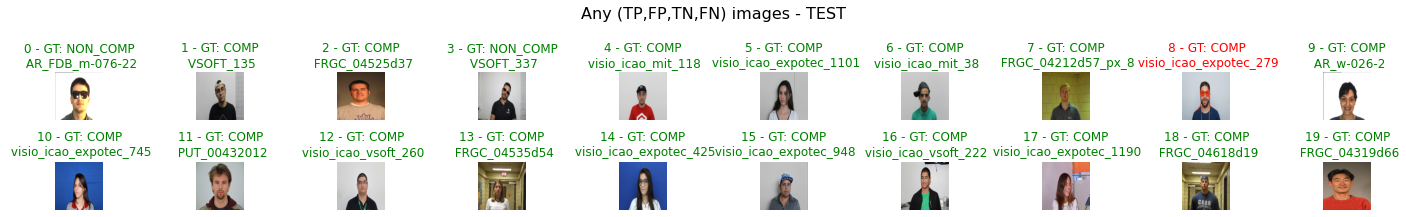

In [9]:
vsoft_ev.vizualize_predictions(n_imgs=20)

### False Positives

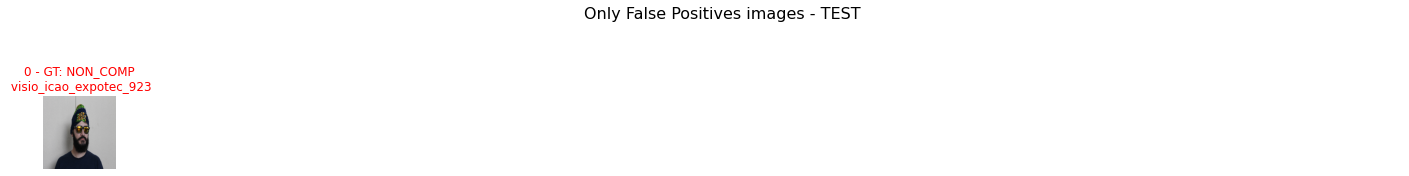

In [10]:
vsoft_ev.vizualize_predictions(n_imgs=10, data_pred_selection=DataPredSelection.ONLY_FP)

### False Negatives

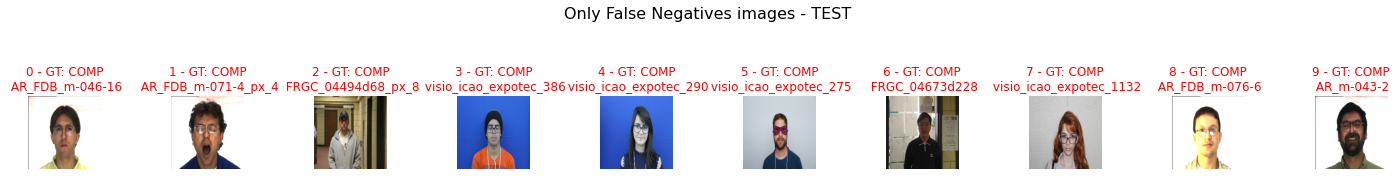

In [11]:
vsoft_ev.vizualize_predictions(n_imgs=10, data_pred_selection=DataPredSelection.ONLY_FN)

### True Positives

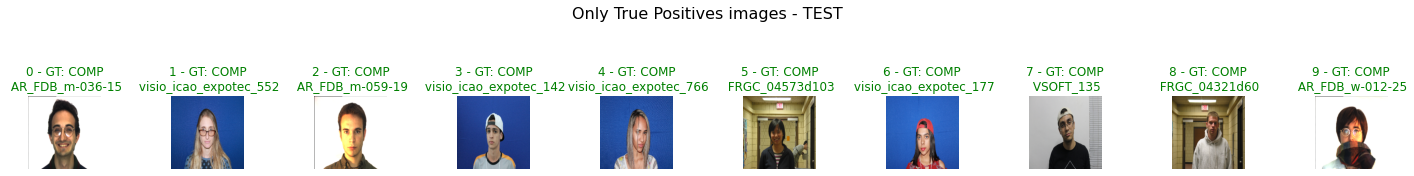

In [12]:
vsoft_ev.vizualize_predictions(n_imgs=10, data_pred_selection=DataPredSelection.ONLY_TP)

### True Negatives

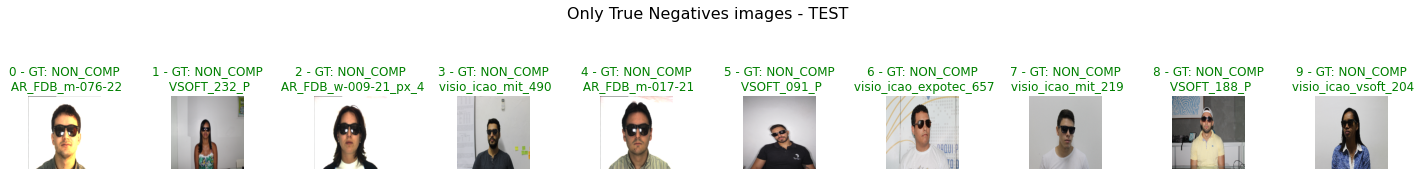

In [13]:
vsoft_ev.vizualize_predictions(n_imgs=10, data_pred_selection=DataPredSelection.ONLY_TN)

## Close

In [14]:
data_src = DataSource.TEST
req = ICAO_REQ.CLOSE

tmp_df = select_vsoft_data(data_df, data_src)

y_true = test_data[req.value].values
y_hat = tmp_df[req.value].values
img_paths = test_data.img_name.values

vsoft_ev = VsoftEvaluator(data_src, img_paths, y_true, y_hat, req)
vsoft_ev.calculate_metrics()

Creating VsoftEvaluator
 .. Data source: TEST
 .. Requisite: CLOSE
 .. n img_paths: 271
 .. n y_true: 271
 .. n y_hat: 271
Testing VSOFT BiopassID ICAO CHECK
Requisite: CLOSE
Classification report -----------------------------------
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         2
         1.0       0.99      1.00      1.00       269

    accuracy                           0.99       271
   macro avg       0.50      0.50      0.50       271
weighted avg       0.99      0.99      0.99       271

Confusion matrix ----------------------------------------
FAR: 100.0% | FRR: 0.0% | EER_mean: 50.0% | TP: 269 | TN: 0 | FP: 2 | FN: 0
Accuracy ------------------------------------------------
Model Accuracy: 99.26%
---------------------------------------------------------


### Any Images

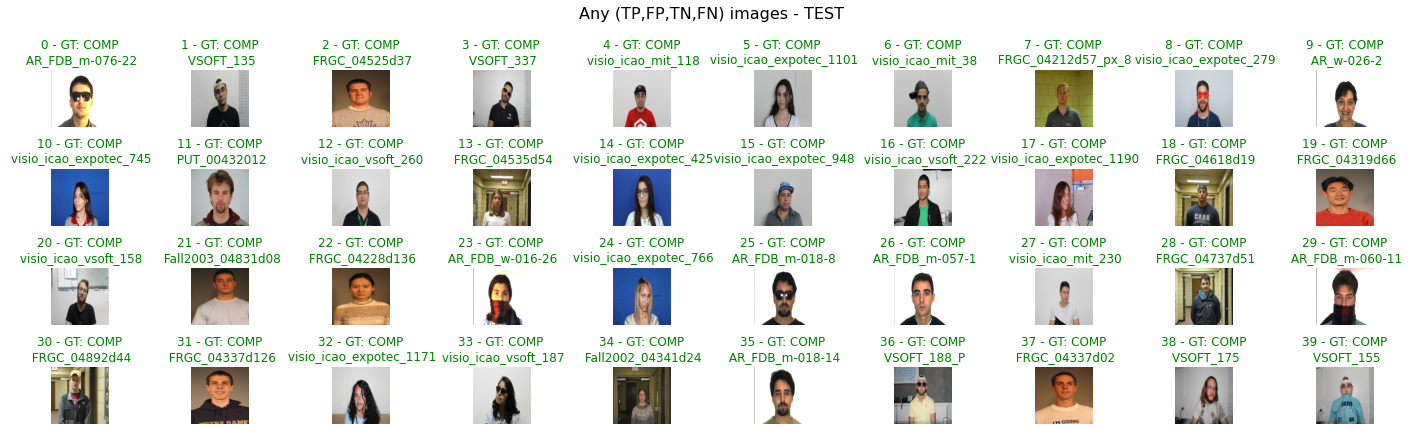

In [15]:
vsoft_ev.vizualize_predictions(n_imgs=40)

### False Positives

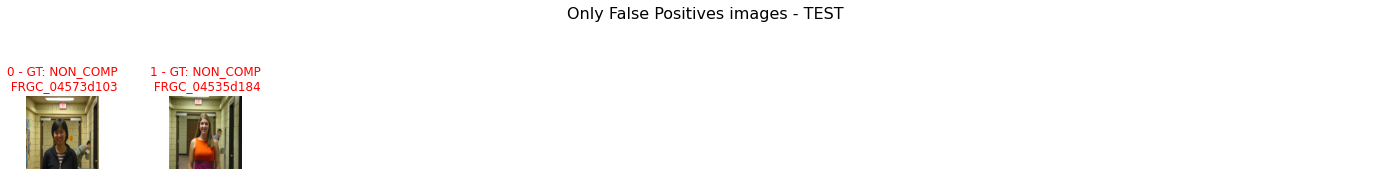

In [16]:
vsoft_ev.vizualize_predictions(n_imgs=10, data_pred_selection=DataPredSelection.ONLY_FP)

### False Negatives

In [17]:
vsoft_ev.vizualize_predictions(n_imgs=50, data_pred_selection=DataPredSelection.ONLY_FN)

### True Positives

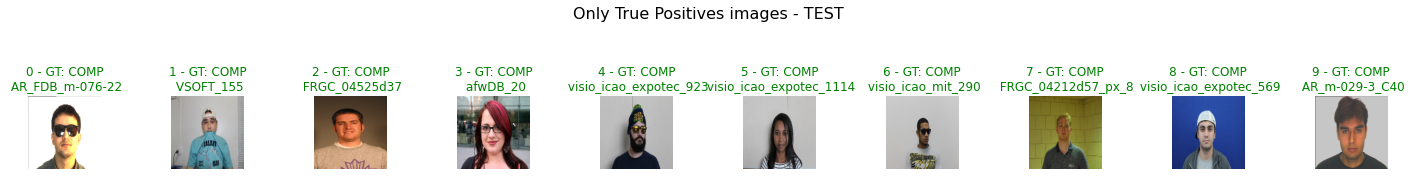

In [18]:
vsoft_ev.vizualize_predictions(n_imgs=10, data_pred_selection=DataPredSelection.ONLY_TP)

### True Negatives

In [19]:
vsoft_ev.vizualize_predictions(n_imgs=10, data_pred_selection=DataPredSelection.ONLY_TN)

## Background

In [20]:
data_src = DataSource.TEST
req = ICAO_REQ.BACKGROUND

tmp_df = select_vsoft_data(data_df, data_src)

y_true = test_data[req.value].values
y_hat = tmp_df[req.value].values
img_paths = test_data.img_name.values

vsoft_ev = VsoftEvaluator(data_src, img_paths, y_true, y_hat, req)
vsoft_ev.calculate_metrics()

Creating VsoftEvaluator
 .. Data source: TEST
 .. Requisite: BACKGROUND
 .. n img_paths: 271
 .. n y_true: 271
 .. n y_hat: 271
Testing VSOFT BiopassID ICAO CHECK
Requisite: BACKGROUND
Classification report -----------------------------------
              precision    recall  f1-score   support

         0.0       0.83      0.67      0.74       126
         1.0       0.76      0.88      0.81       145

    accuracy                           0.78       271
   macro avg       0.79      0.78      0.78       271
weighted avg       0.79      0.78      0.78       271

Confusion matrix ----------------------------------------
FAR: 32.54% | FRR: 12.41% | EER_mean: 22.48% | TP: 127 | TN: 85 | FP: 41 | FN: 18
Accuracy ------------------------------------------------
Model Accuracy: 78.23%
---------------------------------------------------------


### Any Images

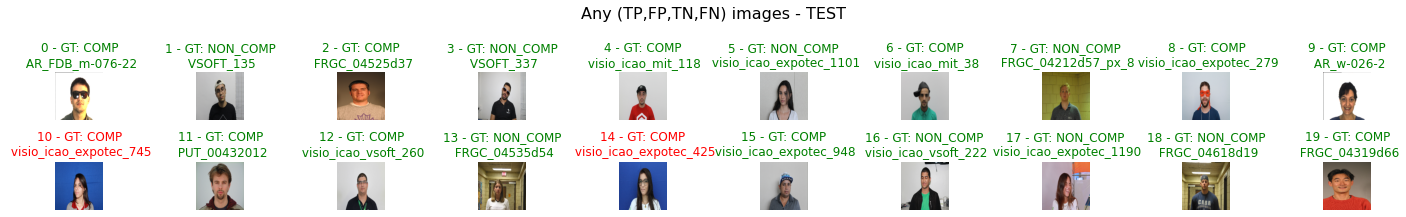

In [21]:
vsoft_ev.vizualize_predictions(n_imgs=20)

### False Positives

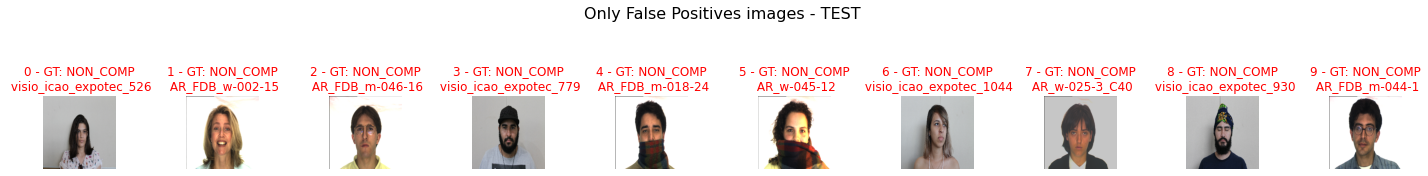

In [22]:
vsoft_ev.vizualize_predictions(n_imgs=10, data_pred_selection=DataPredSelection.ONLY_FP)

### False Negatives

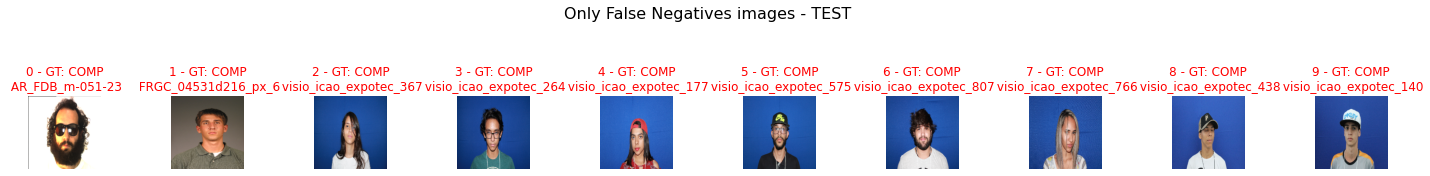

In [23]:
vsoft_ev.vizualize_predictions(n_imgs=10, data_pred_selection=DataPredSelection.ONLY_FN)

### True Positives

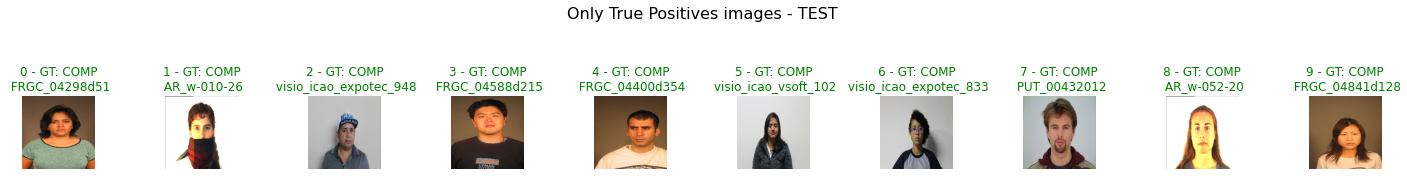

In [24]:
vsoft_ev.vizualize_predictions(n_imgs=10, data_pred_selection=DataPredSelection.ONLY_TP)

### True Negatives

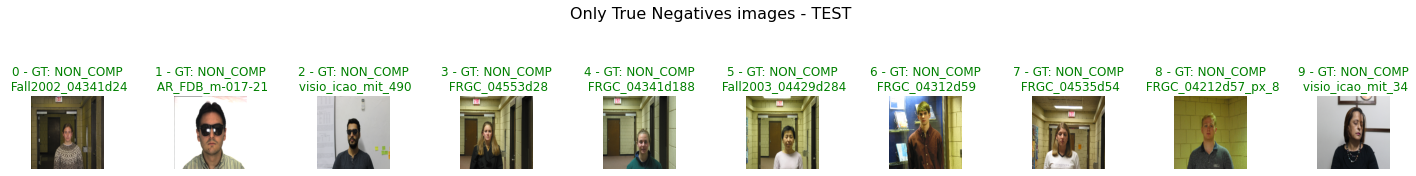

In [25]:
vsoft_ev.vizualize_predictions(n_imgs=10, data_pred_selection=DataPredSelection.ONLY_TN)